## Theory

Suppose that a group of $P$ students is given a test with $I$ multiple choice questions. Let $Y_{pi}=1$ mean that student $p \in \{1, ..., P\}$ has the correct answer on item $i \in \{1, ..., I\}$. Assuming that all responses are conditionally independent given the parameters $a, b, \theta$, we model the outcomes with:

$$Y_{pi} | a,b,\theta \sim Ber(\frac{e^{a_i\theta_p - b_i}}{1 + e^{a_i\theta_p - b_i}})$$

where $\theta_p$ measures the student's learning ability, $a_i$ measures the items discriminatory power, and $b_i$ measures the item's difficulty. Take the following prior assumptions on the distribution of parameters $\theta, a, b$, where all the priors are assumed independent: $a_i \sim \mathcal{N}(0, \sigma_a^2), b_i \sim \mathcal{N}(0, \sigma_b^2), \theta_p \sim \mathcal{N}(0,1)$. Then the posterior distribution of $(a, b, \theta)$ is given by

$$\pi(a,b,\theta | y) = exp\bigr\{ -\frac{1}{2\sigmasq_a^2}||a||^2 - \frac{1}{2\sigmasq_b^2}||b||^2 - \frac{1}{2}||\theta||^2 + \sum_{p,i} y_{pi}(a_i\theta_p - b_i) - log(1 + e^{a_i\theta_p - b_i}) \bigl\}$$

and the full conditionals (the conditional distribution of one variable given all others) are given by

$$\pi(a_i | b,\theta,y) = exp\bigl\{ -\frac{a_i^2}{2\sigma_a^2} + \sum_{p=1}^P a_i y_{pi} \theta_p - log(1+e^{a_i\theta_p - b_i}) \bigr\}$$


$$\pi(b_i | a, \theta, y) = exp\bigl\{ -\frac{b_i^2}{2\sigma_b^2} + \sum_{p=1}^P y_{pi}b_i - log(1+e^{a_i\theta_p - b_i}) \bigr \}$$

$$\pi(\theta_p | a, b, y) = exp\bigl\{ -\frac{\theta_p^2}{2} + \sum_{i=1}^I a_iy_{pi}\theta_p - log(1+e^{a_i\theta_p - b_i}) \bigr\}$$

Since these full conditionals are not easy to sample from, below is an implementation of the Metropolis-within-Gibbs sampler to make sampling easier.

## Implementation: classical and adaptive Metropolis-within-Gibbs

In [1]:
import torch
import matplotlib.pyplot as plt
from tqdm import trange

torch.manual_seed(0)

In [2]:
def loga_conditional(a, b, theta, y, sigmasq):
    """Function to compute the (log) full conditional probability of an observed value of 
    variable a at a given index i. To get the actual conditional probability, raise
    Euler's constant to the power of the returned value.
    
    Parameters
    ----------
    a : torch.tensor
        The observed value of a at index i
    b : torch.tensor
        The observed value of b at index i
    theta : torch.tensor
        A vector of observed theta values
    y : torch.tensor
        The ith column vector of the data Y
    sigmasq : float
        The variance of variable a
        
    Returns
    -------
    prob : torch.tensor
        The (log) conditional probability
    """
    
    assert theta.shape[0] == y.shape[0]
    
    logsum = 0
    for p in range(y.shape[0]):
        logsum += (a * y[p] * theta[p]) - torch.log(1 + torch.exp(a*theta[p]-b))
    
    prob = logsum - (torch.pow(a, 2)/(2*sigmasq))
    return prob

def logb_conditional(b, a, theta, y, sigmasq):
    """Function to compute the (log) full conditional probability of an observed value of 
    variable b at a given index i. To get the actual conditional probability, raise
    Euler's constant to the power of the returned value.
    
    Parameters
    ----------
    a : torch.tensor
        The observed value of a at index i
    b : torch.tensor
        The observed value of b at index i
    theta : torch.tensor
        A vector of observed theta values
    y : torch.tensor
        The ith column vector of the data Y
    sigmasq : float
        The variance of variable a
        
    Returns
    -------
    prob : torch.tensor
        The (log) conditional probability
    """
    
    assert theta.shape[0] == y.shape[0]
    
    logsum = 0
    for p in range(y.shape[0]):
        logsum += ((-1.0*b) * y[p]) - torch.log(1 + torch.exp(a*theta[p]-b))  # trying -1.0x to see if samples better
    
    prob = logsum - (torch.pow(b, 2)/(2*sigmasq))
    return prob

def logtheta_conditional(theta, a, b, y, sigmasq):
    """Function to compute the (log) full conditional probability of an observed value of 
    variable theta at a given index p. To get the actual conditional probability, raise
    Euler's constant to the power of the returned value.
    
    Parameters
    ----------
    a : torch.tensor
        A vector of observed a values
    b : torch.tensor
        A vector of observed b values
    theta : torch.tensor
        The observed value of theta at index p
    y : torch.tensor
        The pth row vector of the data Y
    sigmasq : float
        The variance of variable theta
        
    Returns
    -------
    prob : torch.tensor
        The (log) conditional probability
    """

    assert a.shape == b.shape
    
    logsum = 0
    for i in range(a.shape[0]):
        logsum += (a[i] * y[i] * theta) - torch.log(1 + torch.exp(a[i]*theta - b[i]))
    
    prob = logsum - (torch.pow(theta, 2)/2*sigmasq)
    return prob

In [3]:
def metropolis(prev_sample, sigmasq, avg_acc, full_cond, *full_cond_args):
    """Function to perform random-walk metropolis sampling of a full conditional distribution. 

    Parameters
    ----------
    prev_sample : torch.Tensor
        Previous sampled state, to update or not
    sigmasq : float
        The variance of the random walk
    avg_acc : torch.Tensor
        The running average acceptance rate for the samples
    full_cond : function
        The full conditional distribution from which to sample
    *full_cond_args : tuple
        Additional arguments needed for the full conditional distribution, if any

    Returns
    -------
    update : torch.Tensor
        The next state of the random walk
    """
    
    prop = prev_sample + (torch.distributions.Normal(torch.tensor([0.0]), sigmasq)).sample()
    
    # Ensure that values are within range [0,1]
    if (prop > 1) or (prop < 0):
        A = 0
    else:
        logr = full_cond(prop, *full_cond_args) - full_cond(prev_sample, *full_cond_args)    
        A = torch.min(torch.tensor([1.0]), torch.exp(logr)) 
    #logr = full_cond(prop, *full_cond_args) - full_cond(prev_sample, *full_cond_args)    
    #A = torch.min(torch.tensor([1.0]), torch.exp(logr)) 
        
    U = (torch.distributions.Uniform(torch.tensor([0.0]), torch.tensor([1.0]))).sample()

    update = None
    
    if U <= A:
        update = prop
    else:
        update = prev_sample

    acc_diff = A - avg_acc
    return update, acc_diff


def ada_metropolis(prev_sample, sigmasq, scale, s, avg_acc, full_cond, *full_cond_args, rho=0.6, tau=0.3):
    """Function to perform adaptive random-walk metropolis sampling of a full conditional distribution. 

    Parameters
    ----------
    prev_sample : torch.Tensor
        Previous sampled state, to update or not
    sigmasq : float
        The variance of the random walk
    scale : torch.Tensor
        The scale value for adaptation
    s : int
        Current iteration
    avg_acc : torch.Tensor
        The running average acceptance rate for the samples
    full_cond : function
        The full conditional distribution from which to sample
    *full_cond_args : tuple
        Additional arguments needed for the full conditional distribution, if any

    Returns
    -------
    update : torch.Tensor
        The next state of the random walk
    scale : torch.Tensor
        The updated scale value for adaptation
    acc_diff : torch.Tensor
        A sample-specific value to calculate overall average acceptance rates
    """

    #print(scale.shape)
    prop = prev_sample + (torch.exp(scale)*torch.distributions.Normal(torch.tensor([0.0]), sigmasq).sample())

    # Ensure that sampled values are within [0,1]
    if (prop > 1) or (prop < 0):
        A = 0
    else:
        logr = full_cond(prop, *full_cond_args) - full_cond(prev_sample, *full_cond_args)    
        A = torch.min(torch.tensor([1.0]), torch.exp(logr)) 
    
    #logr = full_cond(prop, *full_cond_args) - full_cond(prev_sample, *full_cond_args)    
    #A = torch.min(torch.tensor([1.0]), torch.exp(logr)) 
    U = (torch.distributions.Uniform(torch.tensor([0.0]), torch.tensor([1.0]))).sample()

    update = None
    
    if U <= A:
        update = prop
    else:
        update = prev_sample

    scale = scale + (1/s**rho)*(A-tau)
    acc_diff = A - avg_acc
    return update, scale, acc_diff

In [4]:
def gibbs(init_a, init_b, init_theta, y, sigmasq_a, sigmasq_b, sigmasq_t, niter=10000, adapt=False):
    """Function to perform Gibbs sampling, using Metropolis-within-Gibbs for the intractable full conditional distributions.

    Parameters
    ----------
    init_a : torch.Tensor
        The initial state of variable a
    init_b : torch.Tensor
        The initial state of variable b
    init_theta : torch.Tensor
        The initial state of variable theta
    y : torch.Tensor
        The data
    sigmasq_a : torch.Tensor
        The prior for the variance of variable a
    sigmasq_b : torch.Tensor
        The prior for the variance of variable b
    sigmasq_t : torch.Tensor
        The prior for the variance of variable theta
    niter : int
        The number of samples to collect

    Returns
    -------
    A : torch.Tensor
        The samples for each element of variable a
    B : torch.Tensor
        The samples for each element of variable b
    THETA : torch.Tensor
        The samples for each element of variable theta
    """
    
    assert init_a.shape == init_b.shape
    assert init_theta.shape[0] == y.shape[0]
    
    I = len(init_a)
    P = len(init_theta)
    
    # samples
    A = torch.empty(size=(niter, I))
    B = torch.empty(size=(niter, I))
    THETA = torch.empty(size=(niter, P))

    # Average acceptance probabilities
    avg_acc_a, avg_acc_b, avg_acc_t = torch.zeros((I,)), torch.zeros((I,)), torch.zeros((P,))
    
    A[0] = init_a
    B[0] = init_b
    THETA[0] = init_theta
    
    if adapt:
        scale_a, scale_b, scale_t = torch.full((I,), -0.2), torch.full((I,), -0.2), torch.full((P,), -0.2)
        print(f"Starting Gibbs sampler with adaptation... \n--------------------------------------------\n")
    else:
        print(f"Starting Gibbs sampler... \n--------------------------------------------\n")
        
    for s in trange(1, niter):

        for i in range(I):
            if not adapt:
                A[s][i], ad = metropolis(A[s-1][i], sigmasq_a, avg_acc_a[i], loga_conditional, B[s-1][i], THETA[s-1], y[:,i], sigmasq_a)
                avg_acc_a[i] = avg_acc_a[i] + (1/s)*ad
            else:
                A[s][i], sc, ad = ada_metropolis(A[s-1][i], sigmasq_a, scale_a[i], s, avg_acc_a[i], 
                                                 loga_conditional, B[s-1][i], THETA[s-1], y[:,i], sigmasq_a)
                avg_acc_a[i] = avg_acc_a[i] + (1/s)*ad
                scale_a[i] = sc
                
        for i in range(I):
            if not adapt:
                B[s][i], ad = metropolis(B[s-1][i], sigmasq_b, avg_acc_b[i], logb_conditional, A[s][i], THETA[s-1], y[:,i], sigmasq_b)
                avg_acc_b[i] = avg_acc_b[i] + (1/s)*ad
            else:
                B[s][i], scale_b[i], ad = ada_metropolis(B[s-1][i], sigmasq_b, scale_b[i], s, avg_acc_b[i], 
                                                         logb_conditional, A[s][i], THETA[s-1], y[:,i], sigmasq_b)
                avg_acc_b[i] = avg_acc_b[i] + (1/s)*ad
                
        for p in range(P):
            if not adapt:
                THETA[s][p], ad = metropolis(THETA[s-1][p], sigmasq_t, avg_acc_t[p], logtheta_conditional, A[s], B[s], y[p,:], sigmasq_t)
                avg_acc_t[p] = avg_acc_t[p] + (1/s)*ad 
            else:
                THETA[s][p], scale_t[p], ad = ada_metropolis(THETA[s-1][p], sigmasq_t, scale_t[p], s, avg_acc_t[p], 
                                                             logtheta_conditional, A[s], B[s], y[p,:], sigmasq_t)
                avg_acc_t[p] = avg_acc_t[p] + (1/s)*ad  
                
    print("Done sampling.")
    print("Average acceptance rates:\n", avg_acc_a, "\n", avg_acc_b, "\n", avg_acc_t) 
    return A, B, THETA

### Tests

In [5]:
# TEST
N = 10000   # iterations
I = 100     # exam items
P = 1000    # pupils

init_a = torch.zeros(I)  
init_b = torch.zeros(I)  
init_t = torch.zeros(P)  

true_a = torch.empty(size=(I,)) #torch.tensor([1, 0.9, 0.01, 0.5, 0.7, 0.4, 0.03, 0.9, 0.8, 1])  # items' discriminatory power
true_b = torch.empty(size=(I,)) #torch.tensor([0.01, 0.9, 1, 0.8, 0.2, 0.3, 0.88, 1, 0.3, 0.5])  # items' difficulty
true_theta = torch.empty(size=(P,)) #torch.tensor([1, 1, 0, 0.5, 0.7, 0.1, 0.3, 0.9, 0.6, 0.7])  # students' skills

# populate a, b:
for i in range(I):
    U = torch.distributions.Uniform(torch.tensor([0.0]), torch.tensor([1.0]))
    true_a[i] = U.sample()
    true_b[i] = U.sample()
    
# populate theta:
for p in range(P):
    U = torch.distributions.Uniform(torch.tensor([0.0]), torch.tensor([1.0]))
    true_theta[p] = U.sample()

# generate exam data:
Y = torch.empty(size=(P, I))

for i in range(I):
    #print(i)
    for p in range(P):
        #print(p)
        prob = torch.exp(true_a[i]*true_theta[p] - true_b[i]) / (1 + torch.exp(true_a[i]*true_theta[p] - true_b[i]))
        B = torch.distributions.Bernoulli(prob)
        Y[p][i] = B.sample()

print(Y)

tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [1., 1., 1.,  ..., 0., 1., 1.]])


#### Classical Metropolis-within-Gibbs Results

In [ ]:
sigmasq_a, sigmasq_b, sigmasq_t = torch.tensor([1.0]), torch.tensor([1.0]), torch.tensor([1.0])  # priors
samples = gibbs(init_a, init_b, init_t, Y, sigmasq_a, sigmasq_b, sigmasq_t, niter=N)

Starting Gibbs sampler... 
--------------------------------------------



  0%|          | 11/9999 [00:54<13:50:37,  4.99s/it]

In [39]:
print("A:")
print(torch.mean(samples[0], 0))  # mean over the columns
print(true_a)

print("B:")
print(torch.mean(samples[1], 0))  # mean over the columns
print(true_b)

print("THETA:")
print(torch.mean(samples[2], 0))  # mean over the columns
print(true_theta)

A:
tensor([0.3400, 0.4051, 0.3261, 0.3798, 0.3917, 0.4121, 0.4594, 0.2987, 0.4218,
        0.3246])
tensor([0.8772, 0.5595, 0.9233, 0.0562, 0.5011, 0.3943, 0.6022, 0.6173, 0.9348,
        0.1170])
B:
tensor([0.7495, 0.5244, 0.7446, 0.6774, 0.7093, 0.6578, 0.4428, 0.8056, 0.6260,
        0.7927])
tensor([0.7489, 0.4967, 0.9230, 0.6897, 0.7321, 0.7261, 0.2069, 0.8396, 0.4205,
        0.7607])
THETA:
tensor([0.4578, 0.3805, 0.4774, 0.4894, 0.3783, 0.4313, 0.4596, 0.4509, 0.4657,
        0.4985, 0.4327, 0.4306, 0.4130, 0.5325, 0.4365, 0.4056, 0.4355, 0.5221,
        0.4543, 0.5049, 0.4056, 0.4555, 0.5106, 0.5131, 0.4668, 0.4347, 0.4274,
        0.4600, 0.4064, 0.5229, 0.4909, 0.5001, 0.4411, 0.3786, 0.5067, 0.4662,
        0.4010, 0.5843, 0.4333, 0.4307, 0.4656, 0.3689, 0.3983, 0.4690, 0.4092,
        0.4918, 0.4613, 0.3732, 0.4390, 0.4280, 0.4772, 0.4412, 0.5278, 0.4627,
        0.4997, 0.4659, 0.4420, 0.4503, 0.4731, 0.4132, 0.4921, 0.4310, 0.4862,
        0.5056, 0.4327, 0.4763, 0.4026,

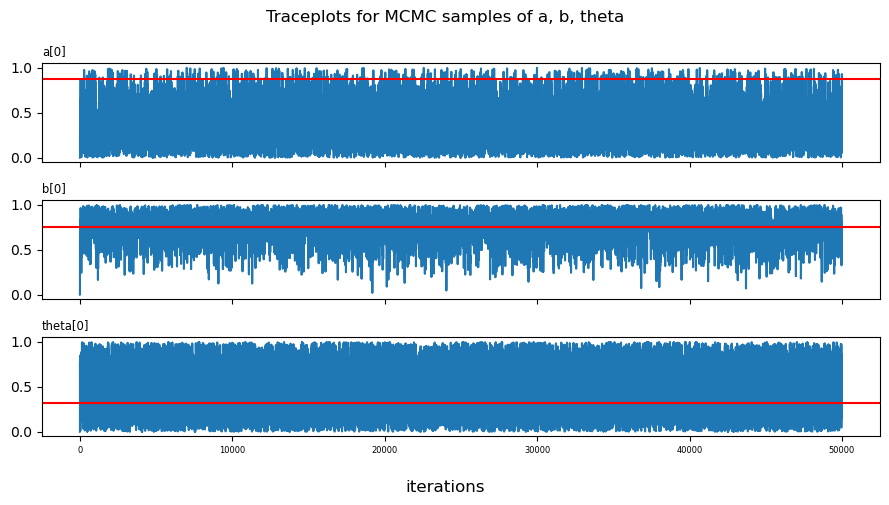

In [40]:
# Traceplots of samples
fig1, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(9,5), sharex=True)
fig1.suptitle('Traceplots for MCMC samples of a, b, theta')

t = range(N)

ax1.plot(t, samples[0][:,0])
ax1.axhline(true_a[0], color="red")
plt.tick_params('x', labelsize=6)
ax1.set_title("a[0]", fontsize='small', loc='left')

ax2.plot(t, samples[1][:,0])
ax2.axhline(true_b[0], color="red")
ax2.set_title("b[0]", fontsize='small', loc='left')

ax3.plot(t, samples[2][:,0])
ax3.axhline(true_theta[0], color="red")
ax3.set_title("theta[0]", fontsize='small', loc='left')

fig1.supxlabel('iterations')
fig1.tight_layout()
plt.show()

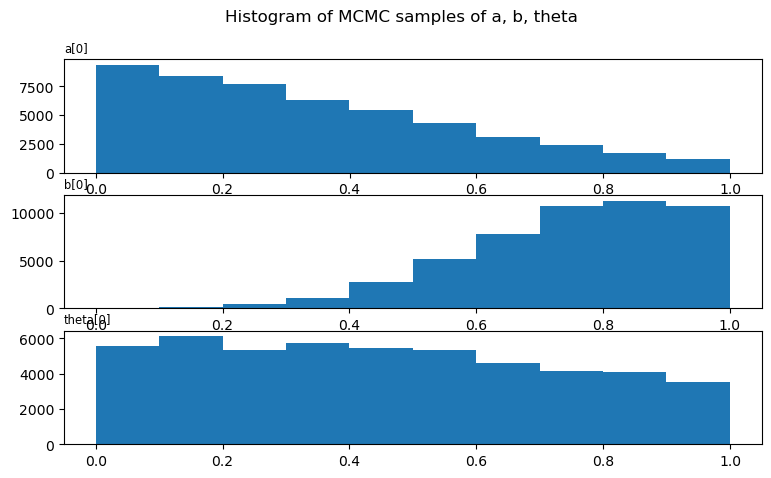

In [41]:
# Histogram of samples
fig2, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(9,5))
fig2.suptitle('Histogram of MCMC samples of a, b, theta')

ax1.hist(samples[0][:,0])
ax1.set_title("a[0]", fontsize='small', loc='left')
ax2.hist(samples[1][:,0])
ax2.set_title("b[0]", fontsize='small', loc='left')
ax3.hist(samples[2][:,0])
ax3.set_title("theta[0]", fontsize='small', loc='left')

plt.show()

#### Adaptive Metropolis-within-Gibbs Results

In [ ]:
sigmasq_a, sigmasq_b, sigmasq_t = torch.tensor([1.0]), torch.tensor([1.0]), torch.tensor([1.0])  # priors
samples_ada = gibbs(init_a, init_b, init_t, Y, sigmasq_a, sigmasq_b, sigmasq_t, niter=N, adapt=True)

Starting Gibbs sampler with adaptation... 
--------------------------------------------



 72%|███████▏  | 7151/9999 [17:47:06<7:00:03,  8.85s/it] 

In [ ]:
fig3, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(9,5), sharex=True)
fig3.suptitle('Traceplots for adaptive MCMC samples of a, b, theta')

t = range(N)

ax1.plot(t, samples_ada[0][:,0])
ax1.axhline(true_a[0], color="red")
plt.tick_params('x', labelsize=6)
ax1.set_title("a[0]", fontsize='small', loc='left')

ax2.plot(t, samples_ada[1][:,0])
ax2.axhline(true_b[0], color="red")
ax2.set_title("b[0]", fontsize='small', loc='left')

ax3.plot(t, samples_ada[2][:,0])
ax3.axhline(true_theta[0], color="red")
ax3.set_title("theta[0]", fontsize='small', loc='left')

fig3.supxlabel('iterations')
fig3.tight_layout()
plt.show()

In [ ]:
# Histogram of samples
fig4, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(9,5), sharex=True)
fig4.suptitle('Histogram of MCMC samples of a, b, theta')

ax1.hist(samples_ada[0][:,0])
ax1.set_title("a[0]", fontsize='small', loc='left')
ax2.hist(samples_ada[1][:,0])
ax2.set_title("b[0]", fontsize='small', loc='left')
ax3.hist(samples_ada[2][:,0])
ax3.set_title("theta[0]", fontsize='small', loc='left')

plt.show()